# Running CHEASE actor

In [1]:
import Pkg
Pkg.activate("../..")
using Revise
using FUSE
using Plots; gr();
global_logger(FUSE.logger);

  Activating project at `~/.julia/dev/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


WebIO._IJuliaInit()

### Initialize the ITER case from ODS
[ITER case documentation](https://fuse.help/cases.html#ITER)

In [3]:
dd, ini, act = FUSE.init(:ITER,init_from=:ods);

┌ Warning: dd.dataset_description was skipped in IMAS data dictionary
└ @ IMASDD ~/.julia/dev/IMASDD/src/data.jl:1067


### Let's run the ActorCHEASE on the ITER equilibrium from the ods and compare 

             now will see if namelist given in file: 'chease_namelist'
  parameters not associated
 NITMOPT =            0
  k1=          182  k2=           40
 in bndfit: end theta points given twice, remove it
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   2.1993927041957479E-002
 eqchease_out(index_out)%profiles_1d%psi(1)=    0.0000000000000000     
 eqchease_out(index_out)%profiles_1d%psi(nbprofiles1d)=    5.3761635021363996E-002
 minval(EQDSPSI)=   -5.3759622974372409E-002
 maxval(EQDSPSI)=   0.12518792719983030     


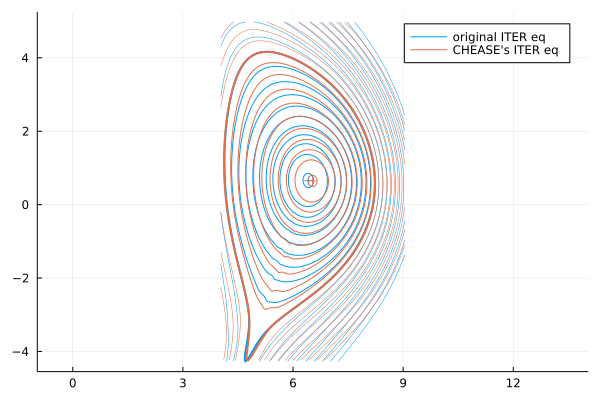

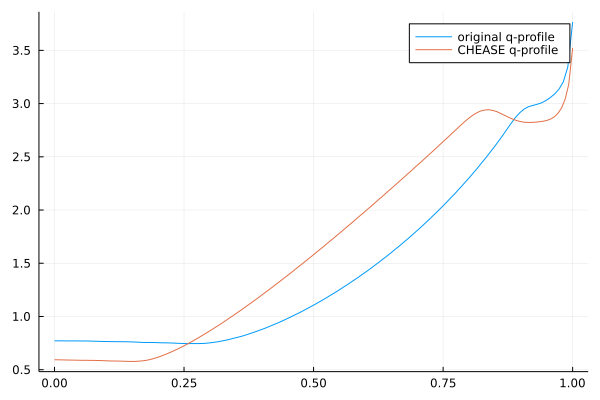

In [6]:
eq_plot = plot(dd.equilibrium, label="original ITER eq")
q_plot = plot(dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="original q-profile")

actor = FUSE.ActorCHEASE(dd,act);
display(plot!(eq_plot,dd.equilibrium, label="CHEASE's ITER eq"))
display(plot!(q_plot,dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="CHEASE q-profile"))


### Running CHEASE on kinetic profiles and steady state current
To do this we need to do a transport step followed by the calculation of the steady-state current

#### Transport

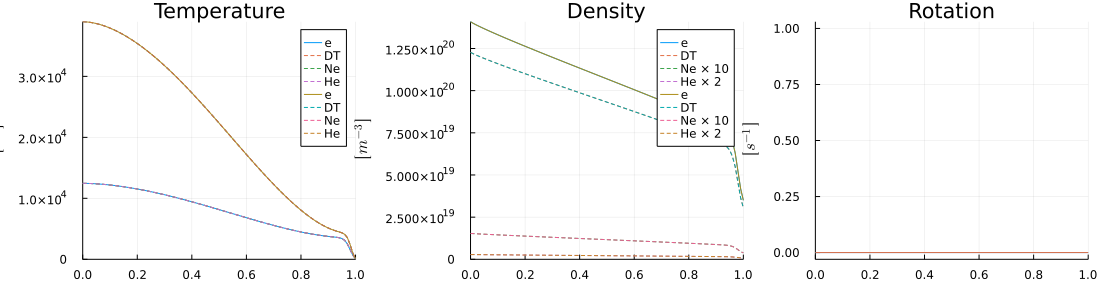

In [11]:
dd, ini, act = FUSE.init(:ITER,init_from=:ods);

core_profiles_plot = plot(dd.core_profiles)
FUSE.ActorSteadyStateCurrent(dd,act)
FUSE.ActorTauenn(dd,act)
plot!(core_profiles_plot,dd.core_profiles)



#### Steady-state current & running CHEASE using kinetic profiles and ss current

             now will see if namelist given in file: 'chease_namelist'
  parameters not associated
 NITMOPT =            0
  k1=          182  k2=           40
 in bndfit: end theta points given twice, remove it
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   6.0433730225476339     
 eqchease_out(index_out)%profiles_1d%psi(1)=    0.0000000000000000     
 eqchease_out(index_out)%profiles_1d%psi(nbprofiles1d)=    6.2785030264072172E-002
 minval(EQDSPSI)=   -6.2780907766112032E-002
 maxval(EQDSPSI)=   0.14011235444960279     


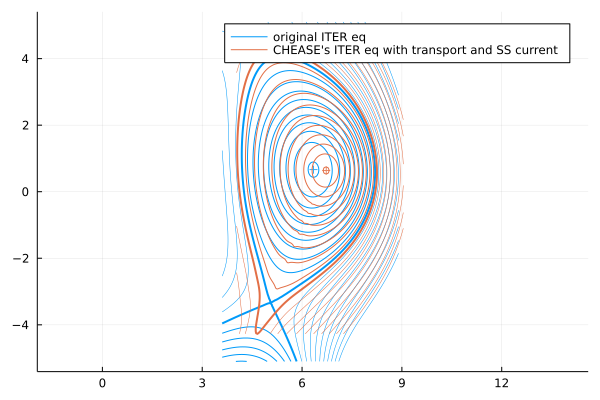

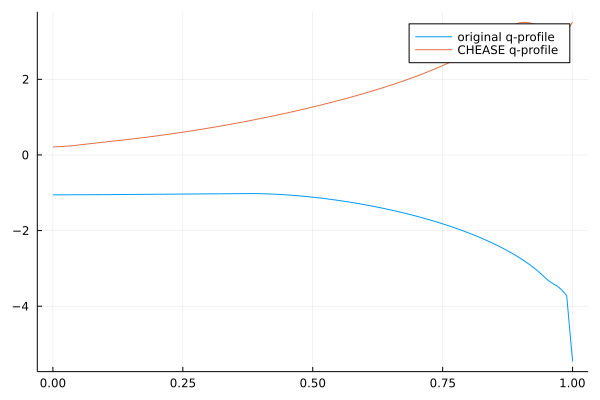

In [14]:
FUSE.ActorSteadyStateCurrent(dd,act);

act.ActorCHEASE.j_tor_from = :core_profiles 
act.ActorCHEASE.pressure_from = :core_profiles

eq_plot = plot(dd.equilibrium, label="original ITER eq")
q_plot = plot(dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="original q-profile")

actor = FUSE.ActorCHEASE(dd,act);
display(plot!(eq_plot,dd.equilibrium, label="CHEASE's ITER eq with transport and SS current"))
display(plot!(q_plot,dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="CHEASE q-profile"))


### Similar analysis for a D3D shot

             now will see if namelist given in file: 'chease_namelist'
  parameters not associated
 NITMOPT =            0
  k1=          182  k2=           40
 in bndfit: end theta points given twice, remove it
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=  0.27294201594085571     
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=  0.13574290828866681     
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   9.0126757022650439E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   6.7445979767920050E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   5.3892256026442598E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   4.4882221434220097E-002
 WARNING, in chipsimetrics

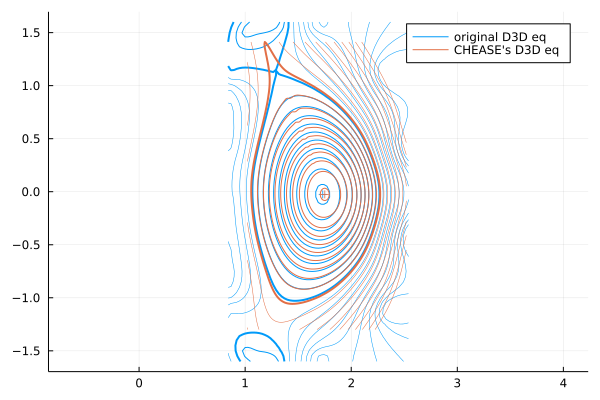

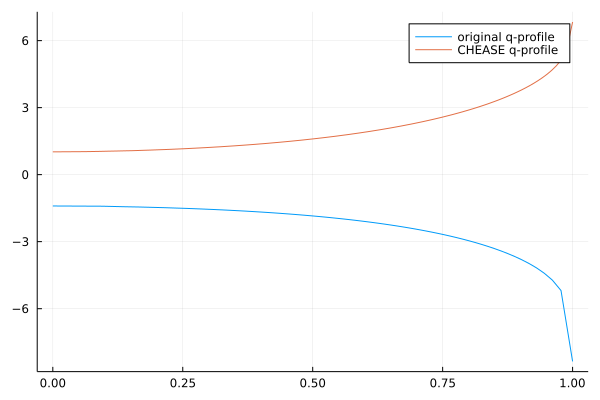

In [15]:
dd, ini, act = FUSE.init(:D3D)

eq_plot = plot(dd.equilibrium, label="original D3D eq")
q_plot = plot(dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="original q-profile")

actor = FUSE.ActorCHEASE(dd,act);
display(plot!(eq_plot,dd.equilibrium, label="CHEASE's D3D eq"))
display(plot!(q_plot,dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="CHEASE q-profile"))


### D3D transport & steady-state current

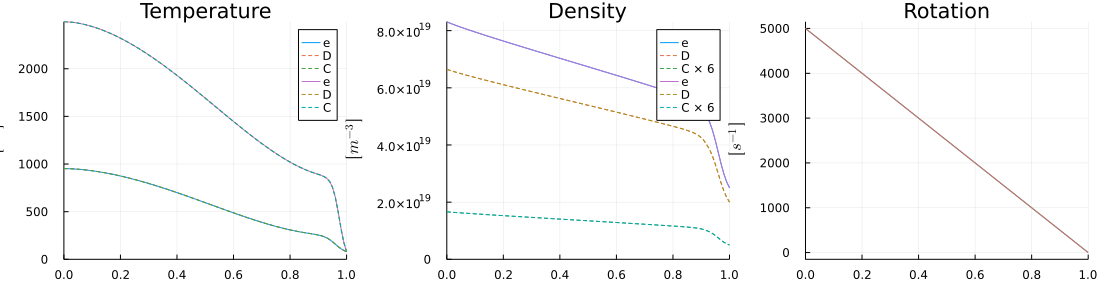

             now will see if namelist given in file: 'chease_namelist'
  parameters not associated
 NITMOPT =            0
  k1=          182  k2=           40
 in bndfit: end theta points given twice, remove it
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=  0.29505133057861316     
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=  0.14474948013331479     
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   9.5815315198722148E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   7.1691061124302971E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   5.7340143555931450E-002
 WARNING, in chipsimetrics.f90, ZTETA(1)~=0, formula used for ZBETCHI0 can not be applied. ZTETA(1)=   4.7826657003942757E-002
 WARNING, in chipsimetrics

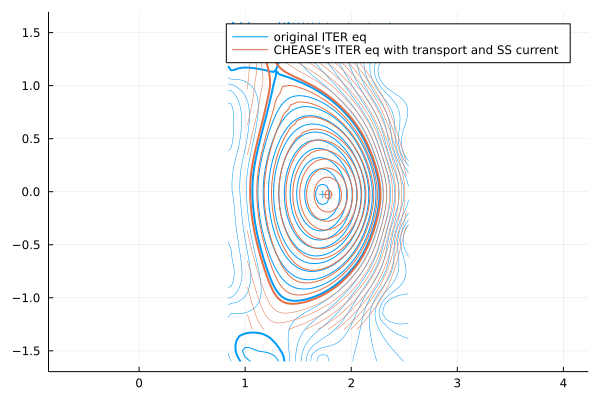

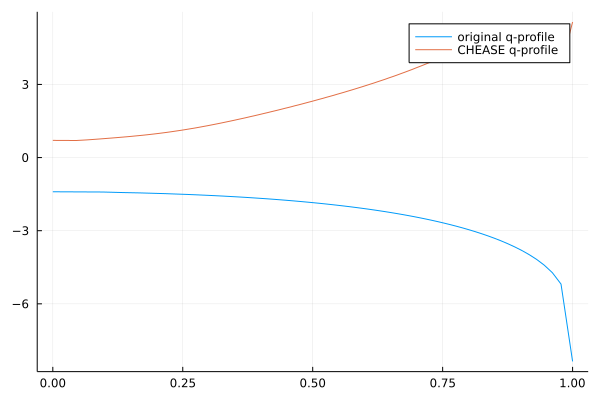

In [18]:
dd, ini, act = FUSE.init(:D3D);

core_profiles_plot = plot(dd.core_profiles)
FUSE.ActorSteadyStateCurrent(dd,act)
FUSE.ActorTauenn(dd,act)
display(plot!(core_profiles_plot,dd.core_profiles))

FUSE.ActorSteadyStateCurrent(dd,act);

act.ActorCHEASE.j_tor_from = :core_profiles 
act.ActorCHEASE.pressure_from = :core_profiles

eq_plot = plot(dd.equilibrium, label="original ITER eq")
q_plot = plot(dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="original q-profile")

actor = FUSE.ActorCHEASE(dd,act);
display(plot!(eq_plot,dd.equilibrium, label="CHEASE's ITER eq with transport and SS current"))
display(plot!(q_plot,dd.equilibrium.time_slice[].profiles_1d.rho_tor_norm,dd.equilibrium.time_slice[].profiles_1d.q,label="CHEASE q-profile"))

